<p style="font-family:Times;font-size:250%; text-align:center"> <font color='red'>Recurrent Neural Network (RNN) dengan Optimizer ADAM</font></p>
<p style="font-family:Times;font-size:200%; text-align:center"> <font color='brown'>Untuk data sekuensial</font></p>

___

# Tugas 2 DL2021
## M.Naufal Irham R. (108181019)

Code di bawah ini tidak banyak diubah agar memudahkan dalam mengkoreksi. Hanya beberapa baris saja yang diubah untuk kebutuhan modifikasi optimizer menjadi optimizer ADAM

In [1]:
from numpy import *   
import numpy as np
from numpy.random import *
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
#sb.set_theme()
sb.set_style("whitegrid")
#sb.set_style("darkgrid")

%matplotlib inline

np.set_printoptions(precision = 3, suppress = True, formatter = {'float':'{:6.5f}'.format})

#Sigmoid function & its derivative
sigmoid = lambda Z: 1/(1+exp(-Z))
dsigmoid = lambda A: A*(1-A)

#ReLU function & its derivative
ReLU  = lambda Z: Z.clip(0)
#Derivative of ReLU function
dReLU = lambda A: (A > 0)*1

#Derivativer of tanh()
dtanh = lambda A: 1-A**2

#Derivative oh arctanh
darctanh = lambda A: 1/(A**2+1)

#Softplus function & its derivative
splus = lambda Z: log(1+exp(Z))
dsplus = lambda A: 1/(1+exp(-A))

linear = lambda X,w,b: X@w+b

"Time step (ts)"
def steps(x, step):   
    obs  = len(x)-step
    xt   = x[:obs,:]
    for i in arange(1,step+1):
        xt = hstack((xt, x[i:obs+i,:]))   
    return xt

In [2]:
class RNN:
    def __init__(self,x,nh,alpha,epochs): # ada h nodes di dalam hidden layer  hlayers = [7, 3, 34, 89]
        self.Xtrain  = x #input
        self.ytrain  = x[:,-1:] #output     
        self.nh = nh   #number of neurons in hidden layer
        self.α  = alpha
        self.epochs = epochs
        self.Ts = shape(self.Xtrain)[1]-1   # Time-steps
        self.N, no = shape(self.ytrain)     #jumlah observasi (self.N) dan jumlah output
        self.ni    = 1  #jumlah input
        
        ###Modifikasi ada dibawah ini######################################
        "Initial values untuk parameter w and b"
        seed(20201212)
        self.neurons = [self.ni, self.nh, no]

        self.w, self.b, self.Vw, self.Mw, self.Vb, self.Mb = [],[],[],[],[],[]

        for i in range(len(self.neurons)-1):
          self.w.append(randn(self.neurons[i], self.neurons[i+1]))
          self.b.append(randn(1, self.neurons[i+1]))
          self.Mw.append(zeros((self.neurons[i], self.neurons[i+1])))
          self.Mb.append(zeros((1, self.neurons[i+1])))
          self.Vw.append(self.Mw[i])
          self.Vb.append(self.Mb[i])

        self.w.append(randn(self.nh,self.nh))
        self.Mw.append(zeros((self.nh,self.nh)))
        self.Vw.append(self.Mw[i+1])
        #####################################################################
        
    def learning(self):
        self.ycap = []
        t = 1 #t adalah berapa kali optimisasi dilakukan
        for i in range(len(self.Xtrain)):
            self.S1 = [zeros((self.ni, self.nh))]  
            self.S2 = []
            ###Modifikasi kecil ada dibawah ini##################
            dCdw0 = zeros_like(self.w[0])
            dCdb0 = zeros_like(self.b[0])
            dCdw1 = zeros_like(self.w[1])
            dCdb1 = zeros_like(self.b[1])
            dCdws = zeros_like(self.w[2])
            
            "Forward propagation in time step"
            for k in range(self.Ts):       
                A0 = self.Xtrain[i,k]
                yk = self.Xtrain[i,k + 1]
            
                # Forward pass, 1st layer
                Z1 = dot(A0,self.w[0]) + self.b[0] + (self.S1[-1]@self.w[2]) 
                A1 = tanh(Z1)
                self.S1.append(copy(A1))   
            
                # Forward pass, 2nd layer
                Z2 = A1@self.w[1] + self.b[1]
                A2 = sigmoid(Z2)
                self.S2.append(copy(A2))
                
            self.ycap.append(A2[0])
            
            "Backward propagation in time step"
            for k in arange(self.Ts)[::-1]:     
                A0 = self.Xtrain[i,k]
                yk = self.Xtrain[i,k + 1]
            
                # Backprop, 2nd layer
                dCdZ2 = -(yk - self.S2[k]) * dsigmoid(self.S2[k])
                dCdw1 += dot(self.S1[k+1].T,dCdZ2)
                dCdb1 += sum(dCdZ2)
            
                # Backprop, 1st layer
                dCdZ1 = dCdZ2@self.w[1].T * dtanh(self.S1[k+1])
                dCdw0 += dot(A0, dCdZ1)
                dCdb0 += sum(dCdZ1)
            
                # Backprob, recurrent layer
                dCdws += dot(self.S1[k].T, dCdZ1)
            #######################################################
            
            ### Modidikasi ada dibawah ini ##################################### 
            "Perubahan parameters (w dan b):"
            beta1   = 0.9
            beta2   = 0.999
            epsilon = 10**(-8) 

            grad = [dCdw0, dCdw1, dCdb0, dCdb1, dCdws]
            "Algoritma ADAM" 
            for i in range(len(self.neurons)-1): #Urutan update: w0&b0 lalu w1&b1

                self.Mw[i] = beta1*array(self.Mw[i]) + (1-beta1)*grad[i]
                self.Vw[i] = beta2*array(self.Vw[i]) + (1-beta1)*grad[i]**2
                
                MwHat = self.Mw[i]/(1-(beta1)**t)
                VwHat = self.Vw[i]/(1-(beta2)**t)

                self.w[i] -= self.α*MwHat/(sqrt(VwHat) + epsilon) #Update parameter w

                self.Mb[i] = beta1*array(self.Mb[i]) + (1-beta1)*grad[i+2]
                self.Vb[i] = beta2*array(self.Vb[i]) + (1-beta1)*grad[i+2]**2
                
                MbHat = self.Mb[i]/(1-(beta1)**t)
                VbHat = self.Vb[i]/(1-(beta2)**t)

                self.b[i] -= self.α*MbHat/(sqrt(VbHat) + epsilon) #Update parameter b

            #Updating untuk ws
            self.Mw[i+1] = beta1*array(self.Mw[i+1]) + (1-beta1)*grad[i+3]
            self.Vw[i+1] = beta2*array(self.Vw[i+1]) + (1-beta1)*grad[i+3]**2
                
            MwHat = self.Mw[i+1]/(1-(beta1)**t)
            VwHat = self.Vw[i+1]/(1-(beta2)**t)

            self.w[i+1] -= self.α*MwHat/(sqrt(VwHat) + epsilon) #Update parameter w

            t += 1
            ###############################################################

#### Contoh #1: Pemakaian RNN untuk memecahkan masalah XOR Gate

In [3]:
X = array([(0,0,0), (1,0,0), (0,1,0), (1,1,1)])   #Input
y = array([[0, 1, 1, 0]])   #Output

Xtrain = array([[1,1,1,0], 
                [1,0,0,1], 
                [0,1,0,1], 
                [0,0,0,0]])
ytrain = y

In [4]:
nh     = 4 
alpha  = 2.5
epochs = 501

"Training"

rnn1 = RNN(Xtrain,nh,alpha,epochs)
tic = datetime.now()

for n in range(epochs):
    rnn1.learning()
    e = rnn1.ycap - ytrain
    sse = dot(e.T,e)/len(ytrain)
    toc = datetime.now()
            
    if n % ((epochs-1)/5) == 0:
        print(f"\nPada epoch ke {n} diperoleh predicted vs actual:")
        print(hstack((array(rnn1.ycap), ytrain.reshape(4,1))))


Pada epoch ke 0 diperoleh predicted vs actual:
[[0.68433 0.00000]
 [0.22131 1.00000]
 [0.63803 1.00000]
 [0.66613 0.00000]]

Pada epoch ke 100 diperoleh predicted vs actual:
[[0.15087 0.00000]
 [0.42725 1.00000]
 [0.88202 1.00000]
 [0.00842 0.00000]]

Pada epoch ke 200 diperoleh predicted vs actual:
[[0.12832 0.00000]
 [0.99371 1.00000]
 [0.94505 1.00000]
 [0.12810 0.00000]]

Pada epoch ke 300 diperoleh predicted vs actual:
[[0.09130 0.00000]
 [0.99146 1.00000]
 [0.96521 1.00000]
 [0.08211 0.00000]]

Pada epoch ke 400 diperoleh predicted vs actual:
[[0.07596 0.00000]
 [0.99418 1.00000]
 [0.97053 1.00000]
 [0.06614 0.00000]]

Pada epoch ke 500 diperoleh predicted vs actual:
[[0.06743 0.00000]
 [0.99524 1.00000]
 [0.97362 1.00000]
 [0.05684 0.00000]]


#### Contoh #2: Pemakaian RNN untuk penaksiran harga saham

___

In [5]:
A  = pd.read_csv('D:/Downloadables/Data/INAF.JK.csv') #Data time series harian harga saham Bank Mandiri sejak 02 Januari 2015
A6 = A['Adj Close'].values   #Ambil kolom ke enam berisi 'Adj Close', 
B  = A6[:,newaxis]  
                                     
Bmin = min(B)
Bmax = max(B)
b = (B-Bmin)/(Bmax-Bmin)

ts = 1   #Di literatur Time Series digunakan istilah 'lag' sebagai padanan istilah 'timestep' ini
xs = steps(b, ts)  #Dihasilkan matriks dengan 2 (= ts+1) kolom, kolom pertama menjadi variabel X
                   #dan kolom terkhir menjadi variabel 
x = xs[-800:,:]    #Ambil 800 observasi terakhir

#Data untuk training
Xtrain = x[0:680,:]   #Ambil 680 observasi yang pertama dan hilangkan kolom terakhir
ytrain = x[0:680:, -1:]  #Ambil 680 observasi yang pertama dan ambil kolom terakhir sebagai variabel y 

#Data untuk testing
Xtest = x[680:, :]   #ambil jumlah observasi sebanyak 120, hilangkan kolom terakhir (untuk y)
ytest = x[680:, -1:] #ambil kolom terakhir

#plt.plot(Xtrain, color = 'b')
#plt.show()

Epoch ke 0, SSE sebesar: 0.02383 dalam waktu 0:00:00.304432
Epoch ke 5, SSE sebesar: 0.00103 dalam waktu 0:00:01.977686
Epoch ke 10, SSE sebesar: 0.00098 dalam waktu 0:00:03.624162
Epoch ke 15, SSE sebesar: 0.00096 dalam waktu 0:00:07.054290
Epoch ke 20, SSE sebesar: 0.00094 dalam waktu 0:00:10.491323
Epoch ke 25, SSE sebesar: 0.00093 dalam waktu 0:00:13.948707


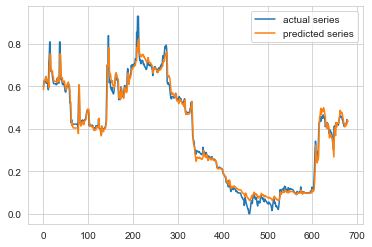

In [6]:
#Ringkasan nh = 3, alpha = 0.27 epochs = 36, ts = 1

nh     = 3  
alpha  = 0.05
epochs = 26

"Training"

rnn2 = RNN(Xtrain,nh,alpha,epochs)
tic = datetime.now()

for n in range(epochs):
    rnn2.learning()
    e = rnn2.ycap - ytrain
    sse = dot(e.T,e)/len(ytrain)
    toc = datetime.now()
            
    if n % ((epochs-1)/5) == 0:
        #print(f"\nPada epoch ke {n} diperoleh predicted vs actual:")
        #print(hstack((array(rnn2.ycap), ytrain.reshape(4,1))))
        print(f"Epoch ke {n}, SSE sebesar: {sse[0][0]:6.5f} dalam waktu {datetime.now()-tic}")

#rnn = RNN(Xtrain,nh,alpha,epochs)
#rnn.training()

plt.plot(ytrain, label = 'actual series')
plt.plot(rnn2.ycap, label = 'predicted series')
plt.legend()
plt.show()

#### Test the model

MSE training: 0.0009338 
MSE testing : 0.0023812


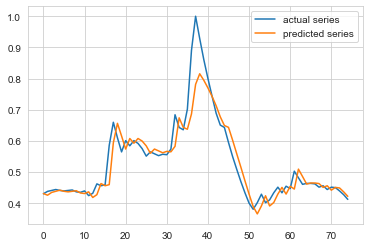

In [7]:
ytestcap = []

for i in range(len(Xtest)):
    S1 = [zeros((1, nh))]  
    S2 = []              
            
    "Forward propagation in time step"
    for k in range(rnn2.Ts):       
        A0 = Xtest[i,k]
        yk = Xtest[i,k + 1]
            
        # Forward pass, 1st layer
        Z1 = dot(A0,rnn2.w[0]) + rnn2.b[0] + (S1[-1]@rnn2.w[2]) 
        A1 = tanh(Z1)
        S1.append(copy(A1))   
            
        # Forward pass, 2nd layer
        Z2 = A1@rnn2.w[1] + rnn2.b[1]
        A2 = sigmoid(Z2)
        rnn2.S2.append(copy(A2))
                
    ytestcap.append(A2[0])

e = ytestcap - ytest
ssetest = dot(e.T,e)/len(ytest)
print('MSE training: %8.7f'%sse,'\nMSE testing : %7.7f'%ssetest)
      
plt.plot(ytest, label = 'actual series')
plt.plot(ytestcap, label = 'predicted series')
plt.legend()
plt.show()